## 导入库

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
PDNA-迁移学习-测试集分开版

"""
import scipy.io as sio
#from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
import tensorflow as tf
import numpy as np
import random
from sklearn.metrics import confusion_matrix

            

## 得到训练集，测试集，验证集

In [3]:
names = locals()
#load benchmark dataset
N_data = sio.loadmat('data\\PDNA-224-ONEHOT-11-N.mat')
P_data = sio.loadmat('data\\PDNA-224-ONEHOT-11-P.mat')
n_X = N_data['n_data']
n_Y = N_data['n_target']
p_X = P_data['p_data']
p_Y = P_data['p_target']

#随机打乱正样本数据并返回
N_p = p_X.shape[0]
print("N_p \t",N_p)
indx = list(range(N_p))
random.shuffle(indx)
p_x=p_X[indx]
p_y=p_Y[indx]

#随机打乱负样本数据并返回
N_n = n_X.shape[0]
print("N_n \t",N_n)
indx = list(range(N_n))
random.shuffle(indx)
n_x=n_X[indx]
n_y=n_Y[indx]

# 得到验证集 1600个

X_test = np.vstack((n_X[52770:53570],p_X[2978:3778]))
Y_test = np.vstack((n_Y[52770:53570],p_Y[2978:3778]))
#随机打乱测试集数据并返回
N_test = X_test.shape[0]
print("N_test \t",N_test)
indx = list(range(N_test))
random.shuffle(indx)
X_test=X_test[indx]
Y_test=Y_test[indx]
X_test = X_test.reshape(len(X_test),-1)
Y_test = Y_test.reshape(len(Y_test),-1)

#处理训练集，正样本数量不变，在剩余52770个负样本中抽取3022个不放回，组成6000条数据为一组的训练集

NN = len(n_X[0:52770])
print(NN)

#负样本批次大小
N_size = 3022
#计算一共有负样本多少个批次
NN_batch = NN // N_size

#print(NN_batch)
a=0
#得到17个数据集，正样本不变，负样本从'PDNA-224-ONEHOT-11-N.mat中抽出3822个不放回
for i in range(NN_batch):
               
        if (i+2)*N_size > NN: #  53570/3022=17.46
                X = np.vstack((n_X[i*N_size:NN],p_X[0:2978]))
                Y = np.vstack((n_Y[i*N_size:NN],p_Y[0:2978]))
        else:
                X = np.vstack((n_X[i*N_size:(i+1)*N_size],p_X[0:2978]))
                Y = np.vstack((n_Y[i*N_size:(i+1)*N_size],p_Y[0:2978]))
                #print(i*N_size)              
        #print(len(X),len(Y))
        #print('')       
        X = X.reshape(len(X),-1)
        Y = Y.reshape(len(Y),-1) 
        #print(X)
        #loo = LeaveOneOut()
        kf = KFold(n_splits=5)
        kf.get_n_splits(X)
        for train_index, test_index in kf.split(X):           
            #得到85个数据集，保存在动态变量中,例如 X_train_1  
            names['X_train_%s' % a],names['X_test_%s' % a]=X[train_index], X[test_index]
            names['Y_train_%s' % a],names['Y_test_%s' % a]=Y[train_index], Y[test_index]
            a+=1





N_p 	 3778
N_n 	 53570
N_test 	 1600
52770


## 计算预测率、混淆矩阵

In [4]:
import matplotlib.pyplot as plt
# 计算预测的准确率
def evalution(y_logists, y_preds):
    correct_prediction = tf.equal(tf.argmax(y_preds, 1),
                                      tf.argmax(y_logists, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    with tf.Session() as sess:
        acc = sess.run(accuracy)
    
    return acc

# 绘制混淆矩阵的函数
# 参数1  cm 混淆矩阵中显示的数值 二维数组
# 参数2 cmap 混淆矩阵中的颜色
# 参数3 title 标题
def plot_confusion_matrix(cm, classes, title='混淆矩阵', cmap=plt.cm.Greens):
    # imshow() 表示绘制并显示二维图 有18个参数
    # 参数1 X 混淆矩阵中显示的数值 二维数组
    # 参数2 cmap 颜色 plt.cm.Blues表示蓝色 plt.cm.Reds表示红色 plt.cm.Greens表示绿色
    # 参数5 interpolation 插值法 一般有如下值
    #     nearest 最近邻插值法
    #     bilinear 双线性插值法
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.imshow(cm, cmap=cmap, interpolation="nearest")
    plt.title(title)  # 标题
    plt.colorbar()  # 显示颜色的进度条
    tick_marks = np.arange(2)  # [0 1]
    plt.xticks(tick_marks, classes)  # 对x轴上分类进行标记
    plt.yticks(tick_marks, classes)  # 对y轴上分类进行标记

    thresh = np.mean(cm)
    for i in range(2):
        for j in range(2):
            plt.text(i, j, cm[j][i],
                     horizontalalignment='center',
                     color='white' if cm[i][j] >= thresh else 'black')

    plt.xlabel('预测值')
    plt.ylabel('真实值')
    



## 卷积神经网络 

In [35]:
#初始化权值
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1) #生成一个截断的正态分布
    return tf.Variable(initial)

#初始化偏置
def bias_variable(shape):
    #initial = tf.truncated_normal(shape,stddev=0.1)
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

#卷积层
def conv2d(x,W):
    #input tensor of shape [batch, in_height, in_width, in_channels]
    #filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]
    #strides[0]=strides[3]=1. strides[1]代表ｘ方向的步长，strids[2]代表ｙ方向的步长
    #padding: A string from "SAME", "VALID"
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')

#池化层
def max_pool_2x2(x):
    #ksize [1,x,y,1]
    return tf.nn.max_pool(x,ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def cnn():
 
    #定义两个placeholder
    x = tf.placeholder(tf.float32, [None, 460])#28*28
    y = tf.placeholder(tf.float32, [None, 2])

    #改变x的格式转为４Ｄ的向量【batch, in_height, in_width, in_channels]
    x_image = tf.reshape(x,[-1, 23, 20 ,1])

    #初始化第一个卷积层的权值和偏量
    W_conv1 = weight_variable([7,7,1,32])#5*5的采样窗口，３２个卷积核从１个平面抽取特征
    b_conv1 = bias_variable([32])#每一个卷积核一个偏置值

    #把x_image和权值向量进行卷积，再加上偏置值，然后应用于relu激活函数
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)#进行max-pooling

#     #初始化第二个卷积层的权值和偏置
#     W_conv2 = weight_variable([5,5,32,64]) #5*5的采样窗口，64个卷积核从32个平面抽取特征
#     b_conv2 = bias_variable([64]) #每一个卷积核一个偏置值

#     #把H_pool1和权值向量进行卷积，再加上偏置值，然后应用于relu激活函数
#     h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#     h_pool2 = max_pool_2x2(h_conv2)

#     #23*20的图片第一次卷积后还是23*20,第一次池化后变为12*10
#     #第二次卷积后为12*10,第二次池化后变为6*5
#     #进过上面操作后得到64张6*5的平面

    #初始化第一全链接层的权值
    W_fc1 = weight_variable([12*10*32,512]) #上一层有7*7*64个神经元,全连接层有1024个神经元
    b_fc1 = bias_variable([512])

    #把池化层2的输出扁平化为1维
    
    h_pool2_flat = tf.reshape(h_pool1,[-1,12*10*32])
    #求第一个全连接层的输出
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    #keep_prob用了表示神经元的输出概率
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob)

    #初始化第二个全连接层
    W_fc2 = weight_variable([512,2])
    b_fc2 = bias_variable([2])

    #计算输出
    pred = tf.nn.softmax(tf.matmul(h_fc1_drop,W_fc2) + b_fc2)

    #交叉熵代价函数
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred))
    
    #使用AdamOptimizer进行优化
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

    #结果存放在一个布尔列表中
    correct_prediction = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
    #求准确率
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(10):
            for i in range(84):
                
                
                batch_xs = names['X_train_%s' % i]
                batch_ys = names['Y_train_%s' % i]
                #batch_xs,batch_ys = mnist.train.next_batch(batch_size)
                sess.run(train_step,feed_dict={x:batch_xs,y:batch_ys,keep_prob:0.5})
                
            acc = sess.run(accuracy, feed_dict={x:names['X_test_%s' % i], y:names['Y_test_%s' % i], keep_prob:1.0})
            cross_entropy1 = sess.run(cross_entropy, feed_dict={x:names['X_test_%s' % i], y:names['Y_test_%s' % i], keep_prob:1.0})
            print('迭代次数 '+str(epoch) + "，Testing Accuracy=" + str(acc)+',cross_entropy1= '+str(cross_entropy1))

            
            
        y_pred,acc1 = sess.run([pred,accuracy], feed_dict={x:X_test, y:Y_test, keep_prob:1.0})
        print(acc1)
        
    return y_pred

## 训练

In [36]:
y_pred=cnn()

迭代次数 0，Testing Accuracy=1.0,cross_entropy1= 0.31326163
迭代次数 1，Testing Accuracy=1.0,cross_entropy1= 0.31326163
迭代次数 2，Testing Accuracy=1.0,cross_entropy1= 0.31326163
迭代次数 3，Testing Accuracy=1.0,cross_entropy1= 0.31326163


KeyboardInterrupt: 

## 画出混淆矩阵

[0 1 0 ... 0 1 1] [1 1 1 ... 1 1 1]
[[  0 800]
 [  0 800]]
recall:  0.0


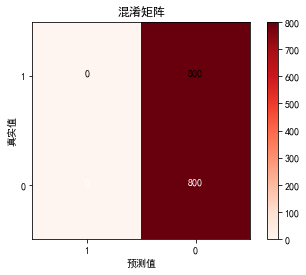

In [16]:
#混淆矩阵
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    #print(y_logists)
    
    a=tf.argmax(Y_test,1)
    b=tf.argmax(y_pred,1)
    xx=sess.run(a)
    yy=sess.run(b)
    print(xx,yy)
    #cnf_matrix = confusion_matrix(y_logists[:,0], y_preds[:,0])
    cnf_matrix = confusion_matrix(xx, yy)
    print(cnf_matrix)
    recall = cnf_matrix[0][0] / (cnf_matrix[0][0] + cnf_matrix[0][1])
    print('recall: ', recall)
    plot_confusion_matrix(cnf_matrix, [1, 0], cmap=plt.cm.Reds)
